In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np 
import emoji
import string
import re
import nltk
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

#bokeh 
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, Panel, Tabs, FactorRange
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.palettes import Spectral5
import bokeh.layouts as layouts
from bokeh.layouts import row
import bokeh.models.widgets as widgets
from bokeh.io import curdoc
from bokeh.transform import factor_cmap
from bokeh.transform import dodge
output_notebook()

# Set iPython's max column width to 1000
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:,.3f}'.format


Loading BokehJS ...

In [3]:
df = pd.read_json('fin_dis_tweet.json')

In [4]:
retweets = pd.DataFrame(df.groupby(['retweetID','original_text']).retweetID.count().sort_values(ascending=False))
retweets.head(20)

,,retweetID
retweetID,original_text,
"1,187,535,711,000,000,000.000","RT @lobo240z: Fuck a fake ID, who makes fake Disneyland annual passes",14445
"1,158,839,596,000,000,000.000","“Quick, act like this is your first tasting of the day” #🥴 #weekend #winetasting #jumpsuit #mrturk #californiaadventure #clothedcontent https://t.co/NbpoKzBuiU",7517
"1,188,852,344,000,000,000.000",RT @TheSocietyDude: This guy is ready for whatever Disneyland will throw at him https://t.co/ZawaczjFax,6652
"1,185,059,536,000,000,000.000",RT @babyhanners: I wish I was at Disneyland eating a churro right now,5140
"1,190,101,152,000,000,000.000",✨✨✨✨✨✨✨\n 5組10名様を\n#東京ディズニーランド®\n 新オープン施設の\n プレビューにご招待！\n✨✨✨✨✨✨✨\n\n新施設をいち早く体験するチャンス✧٩(ˊωˋ*)و✧\n\nこのツイートをリツイートして応募してね！\n\n#パークチケットもついてるよ🎁\n#JALプレビューチケットキャンペーン\n\n▼詳細▼,3135
"1,184,630,277,000,000,000.000",People kept stopping me all day at Tokyo Disneyland with lovely compliments and asking for pictures! There’s no face character for Tiana in the Japan parks so people really responded well to seeing one at TDL. More love for Princess Tiana in Japan yes 😍💚 https://t.co/wvEC7hVwBg,3100
"1,179,510,293,000,000,000.000","RT @iamAdrianRomero: It’s always “wyd”, never, “lets go to Disneyland”.",3100
"1,183,939,195,000,000,000.000",RT @Dream_GoesOn: ワンマン初回、今日から新演出…？これは泣くよ…😭\n#TDR_now https://t.co/tHqRj5fhgs,1843
"1,185,941,050,000,000,000.000","Yesterday I went into the Cantina at the new Star Wars land at Disneyland and the bartender leans over, sneakily gives me this, and whispers, “It’s not often we get a Resistance General in here. Thank you for your service.” I almost cried. https://t.co/JM2YpRo2aF",1814


In [5]:
df.retweet_count.replace(np.nan,0, inplace = True)
df2 = df.drop_duplicates(subset = 'clean_text')

In [6]:
df2_ja = df2[df2['language'] == 'ja']
df2_ja = df2_ja.reset_index(drop= True)

In [7]:
df2_en = df2[df2['language'] == 'en']
df2_en = df2_en.reset_index(drop = True)
df2_en['word_trans'] = 'None'
df2_en['google_trans'] = 'None'

In [8]:
goog_trans = pd.read_csv('goog_trans.csv', header = None)

In [9]:
word_trans = pd.read_csv('word_trans.csv', header = None)

In [10]:
goog_trans.columns = ['index', 'goog_trans']
word_trans.columns = ['index', 'word_trans']

In [11]:
df2_ja['word_trans'] = word_trans['word_trans']
df2_ja['google_trans'] = goog_trans['goog_trans']

In [12]:
df3 = pd.concat([df2_en, df2_ja]).sort_values('created')
df3 = df3.reset_index(drop = True)

In [13]:
df3 = df3.drop(columns=['clean_translated_text', 'clean_text', 'text_length', 'clean_text_hashtag','clean_text_hashtag_emoji',
                'polarity_tb', 'subjectivity_tb', 'sentiment_text_blob','vader_pos','sentiment_vader','vader_score',
                'original_clean_text_hashtag_emoji','sentiment_asari','clean_text_hashtag_emoji_mentions',
                 'original_clean_text_hashtag_emoji_mentions','disneyAnaheim', 'disneyTokyo','otherdisneyparks','park',
                        'hashtag','emoji','mentions'])

In [14]:
df3['en_ja_word'] = np.where((df3['word_trans'] == 'None'), df3['original_text'], df3['word_trans'])

In [15]:
df3['en_ja_goog'] = np.where((df3['google_trans'] == 'None'), df3['original_text'], df3['google_trans'])

In [16]:
df3 = df3.drop(columns = ['word_trans','google_trans'])

In [17]:
df3['en_ja_word'] = df3['en_ja_word'].astype('str')
df3['en_ja_goog'] = df3['en_ja_goog'].astype('str')

In [18]:
#extract link for tweet
def tweet_link(link):
    words = link.split()
    links = [word for word in words if word.startswith('http')]
    return links

In [19]:
df3['tweet_link'] = df3['original_text'].apply(tweet_link)

In [20]:
#extract Hashtags
def hashtags(string):
    words = string.split()
    hashtags = [word for word in words if word.startswith('#')]
    return hashtags

In [21]:
df3['hashtag'] = df3['original_text'].apply(hashtags)

In [22]:
#hashtag count
def hash_count(string):
    words = string.split()
    hashtags = [word for word in words if word.startswith('#')]
    return len(hashtags)

In [23]:
df3['hash_count'] = df3['original_text'].apply(hash_count)

In [24]:
#Extract mention
def mention(string):
    words = string.split()
    mention = [word for word in words if word.startswith('@')]
    return mention

In [25]:
df3['mention'] = df3['original_text'].apply(mention)
df3['mention_count']  = df3['mention'].apply(len)

In [26]:
#extracting the emojis
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
#English
df3['emoji'] = df3['original_text'].str.findall(r)

In [27]:
#Emoji count
df3['emoji_count'] = df3['emoji'].apply(len)

In [28]:
#Translation is about the same so we will stick with our word translation 
df3[['en_ja_word','en_ja_goog']].head(20)

,en_ja_word,en_ja_goog
0,"RT @tdrblognote: Is this the new Mickey flower bed? If you're going to make an event photo location, it's the World Bazaar side. There is no space on the Mickey side to put the photo location. #TDR_now https://t.co/xYEQmaDLHm He Sia","RT @tdrblognote: This is the new Mickey flower beds Is - is a separate type. If you are making event photo locations, are you on the World Bazaar side? There is no space for photo location on Mickey side. #TDR_now https://t.co/xYEQmaDLHm"
1,"@OrangeGrove55 Galaxy’s Edge at Walt Disney World isn’t a failure, but like Disneyland it’s underperforming. But how can it not when they set it up to fail by not opening Rise with the land and not having Mickey’s Runaway Railway open. People are holding back. How many? Who knows?","@OrangeGrove55 Galaxy’s Edge at Walt Disney World isn’t a failure, but like Disneyland it’s underperforming. But how can it not when they set it up to fail by not opening Rise with the land and not having Mickey’s Runaway Railway open. People are holding back. How many? Who knows?"
2,"RT @hp_yec: I thought it was different from yesterday, but Mickey flower bed was back! Come home! #TDR_now https://t.co/KUib5PtJlT\n\n\n","RT @hp_yec: When I thought something was different from yesterday, I \nwas back at Mickey Flowerbed! \nwelcome home! \n\n#TDR_now https://t.co/KUib5PtJlT"
3,RT @gourmetdyy: New #Halloween themed cups! #ShanghaiDisneyland #SHDL #上海ディズニーランド #Disney #Disneypark #Disneyland #Duffy https://t.co/2fa…,RT @gourmetdyy: New #Halloween themed cups! #ShanghaiDisneyland #SHDL #上海ディズニーランド #Disney #Disneypark #Disneyland #Duffy https://t.co/2fa…
4,Why would Disney need to promote #StarWars: #GalaxysEdge so much if everything is hunky-dory?,Why would Disney need to promote #StarWars: #GalaxysEdge so much if everything is hunky-dory?
5,RT @MezzoMikiD: Mickey flower bed renewed \nfrom Tokyo Disneyland today has appeared https://t.co/6tEyanANLs\nhttps://t.co/SxFWw679bW,RT @MezzoMikiD: Tokyo Disneyland \nMickey flowerbed renewed from today has appeared ☆ \nhttps://t.co/6tEyanANLs https://t.co/SxFWw679bW
6,"You could win a vacation for four to a galaxy far, far away. Enter now: https://t.co/lTGaULfzkH @SouthwestAir @WaltDisneyWorld @Disneyland #StarWars #Sweepstakes #NoPurchaseNecessary","You could win a vacation for four to a galaxy far, far away. Enter now: https://t.co/lTGaULfzkH @SouthwestAir @WaltDisneyWorld @Disneyland #StarWars #Sweepstakes #NoPurchaseNecessary"
7,RT @_erikagirl00: a bitch just wants to go to Disneyland..,RT @_erikagirl00: a bitch just wants to go to Disneyland..
8,RT @EricMMrozek: Why would Disney need to promote #StarWars: #GalaxysEdge so much if everything is hunky-dory? https://t.co/WSTNWb85Za,RT @EricMMrozek: Why would Disney need to promote #StarWars: #GalaxysEdge so much if everything is hunky-dory? https://t.co/WSTNWb85Za
9,To Popcorn Bucket or not to Popcorn Bucket? That is the question...The answer is always to Popcorn Bucket!🎃😈#halloweentime #disneyland https://t.co/mq9rzy72qT,To Popcorn Bucket or not to Popcorn Bucket? That is the question...The answer is always to Popcorn Bucket!🎃😈#halloweentime #disneyland https://t.co/mq9rzy72qT


In [29]:
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
punc = lambda x: re.sub("!|,|\?|\'|-|\"|&|。|\)|\(|！|，|\.*|/|\[|\]|\u2026|\d|:|~|、|？|☆|’|– |【|】|「|」|《|》|※| “|”|＊|→||[\b\.\b]{3}||@||@ |#|# |", '',x)

#Clean
def clean_text(soup):
    soup = BeautifulSoup(soup, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(r'https?://[A-Za-z0-9./]+', '', souped)
    words = stripped.split() 
    mention = [word for word in words if not word.startswith('@')]
    RT = [word for word in mention if not word.startswith('RT')]
    text = " ".join([wn.lemmatize(word) for word in RT if word not in stopwords])
    punct = "".join([word.lower() for word in text if word not in string.punctuation])
    short_words = ' '.join([w for w in punct.split() if len(w)>2])
    ja_punct = ''.join([punc(word) for word in short_words])
    tokens = re.split('\W+', ja_punct)
    return (" ".join(tokens)).strip()

In [30]:
df3['clean_text'] = df3['en_ja_word'].apply(clean_text)

/Users/justin/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "https://t.co/wk51gpaVdJ" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/justin/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "https://t.co/iEwFr5J96y

Whoops!" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [31]:
df3['clean_text'][0:30]

0     new mickey flower bed going make event photo location world bazaar side there space mickey side put photo location tdrnow sia                                                                                      
1     galaxys edge walt disney world isnt failure like disneyland its underperforming but set fail opening rise land mickeys runaway railway open people holding back how many who knows                                 
2     thought different yesterday mickey flower bed back come home tdrnow                                                                                                                                                
3     new halloween themed cups shanghaidisneyland shdl 上海ディズニーランド disney disneypark disneyland duffy                                                                                                                    
4     why would disney need promote starwars galaxysedge much everything hunkydory                                              

In [32]:
#Add in our R sentiment for range of emotion
r_sent_word = pd.read_csv('r_sent_word.csv', index_col = 0)
r_sent_word = r_sent_word.reset_index(drop = True)

In [33]:
r_sent_word_counts = pd.DataFrame(r_sent_word.astype(bool).sum().reset_index())
r_sent_word_counts = r_sent_word_counts.rename(columns = {'index':'sentiment',0:'count'})

In [34]:
#Bokeh Chart 
sentiment = list(r_sent_word_counts['sentiment'])
count = list(r_sent_word_counts['count'])


source = ColumnDataSource(data=dict(sentiment=sentiment, count=count))

p = figure(x_range=sentiment, y_range=(0,50000),  plot_width=700, plot_height=700, title="R Sentiment Count",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p.vbar(x='sentiment', top='count', width=0.9, color = 'red', source=source)
p.title.align = 'center'
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = "vertical"
p.left[0].formatter.use_scientific = False
p.add_tools(HoverTool(tooltips=[("sentiment", "@sentiment"), ("Total Count", "@count")]))


p.title.text_font_size = '20pt'
p.xaxis.axis_label="Sentiment"
p.xaxis.axis_label_text_font_size = "15pt"
p.xaxis.major_label_text_font_size = "15pt"
p.xaxis.axis_label_text_color = "black"
p.yaxis.axis_label="Count"
p.yaxis.axis_label_text_font_size = "15pt"
p.yaxis.major_label_text_font_size = "15pt"
p.yaxis.axis_label_text_color = "black"


tbsource = ColumnDataSource(r_sent_word_counts)

columns = [TableColumn(field = 'sentiment', title = 'Sentiment'),
          TableColumn(field = 'count', title = 'Count')]
data_table = DataTable(source = tbsource, columns = columns, width = 700, height = 700)

layout = row(p, data_table)

show(layout)

In [35]:
df3 = pd.concat([df3,r_sent_word],axis =1 )

In [36]:
# load in our R tie breaker sentiment
r_sent = pd.read_csv('r_senti_word.csv', index_col=0)
r_sent = r_sent.reset_index(drop = True)
df3['r_sentiment'] = r_sent

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    if score['compound']>= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [38]:
vader = lambda x: sentiment_analyzer_scores(x)
df3['vader_score_word'] = [vader(x) for x in df3['clean_text']]

In [39]:
from textblob import TextBlob

def get_tweet_sentiment(tweet):
    # create TextBlob object of passed tweet text
    analysis = TextBlob(tweet)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [40]:
df3['tb_word'] = df3['clean_text'].apply(lambda tweet: get_tweet_sentiment(tweet))

In [41]:
#Creating the tie breaker between textblob,vader and r_sentiment

test = np.where((df3['vader_score_word'] == df3['tb_word']), df3['vader_score_word'], 'not sure')
test2 = np.where((df3['tb_word'] == df3['r_sentiment']), df3['tb_word'], 'not sure')
test3 = np.where((df3['vader_score_word'] == df3['r_sentiment']), df3['vader_score_word'], 'not sure')


test = pd.DataFrame(test)
test.rename(columns = {0:'vaderVstb'}, inplace = True)
test['tbVsr'] = test2
test['vaderVsr'] = test3


t2 = np.where(test['vaderVstb'] == 'not sure', test['tbVsr'], test['vaderVstb'])
t2 = pd.DataFrame(t2)
t2.rename(columns = {0:'compare1'}, inplace = True)
t2['compare2'] = np.where(t2['compare1'] == 'not sure', test['vaderVsr'], t2['compare1'])

#Remaining 5510 rows still not sure.  Since vader analyzes emoticons better we will use vader as the final tie breaker
t2['compare3'] = np.where(t2['compare2'] == 'not sure', df3['vader_score_word'], t2['compare2'])
df3.loc[:,'label'] = t2.loc[:,'compare3']

In [42]:
#Feature Creation 
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

In [43]:
df3['punc_count'] = df3['original_text'].apply(lambda tweet: count_punct(tweet))
#counting length of tweet
df3['tweet_len'] = df3['en_ja_word'].apply(lambda tweet: len(tweet) - tweet.count(' '))

In [44]:
df3['tweet_len'].describe()

count   87,510.000
mean    103.565   
std     63.420    
min     0.000     
25%     56.000    
50%     92.000    
75%     130.000   
max     873.000   
Name: tweet_len, dtype: float64

In [45]:
#number of capitlizatized words
def count_cap(text):
    count = sum([1 for c in text if c.isupper()])
    return count

In [46]:
df3['cap_count'] = df3['en_ja_word'].apply(count_cap)

/Users/justin/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


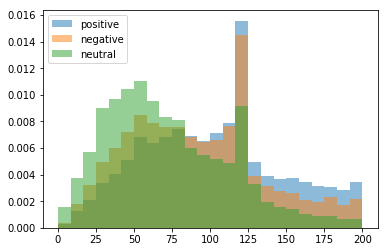

In [47]:
#feature evaluation
#tweet length
bins = np.linspace(0,200,25)
plt.hist(df3[df3['label']=='positive']['tweet_len'], bins, alpha =0.5,normed = True, label ='positive')
plt.hist(df3[df3['label']=='negative']['tweet_len'], bins, alpha =0.5,normed = True, label ='negative')
plt.hist(df3[df3['label']=='neutral']['tweet_len'], bins, alpha =0.5,normed = True, label ='neutral')
plt.legend(loc='upper left')
plt.show()



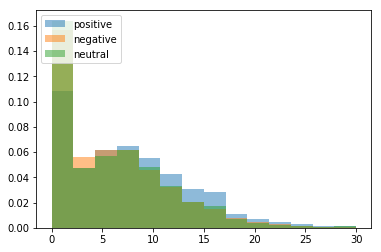

In [48]:
#punctuation count
bins = np.linspace(0,30,15)
plt.hist(df3[df3['label']=='positive']['punc_count'], bins, alpha =0.5,normed = True, label ='positive')
plt.hist(df3[df3['label']=='negative']['punc_count'], bins, alpha =0.5,normed = True, label ='negative')
plt.hist(df3[df3['label']=='neutral']['punc_count'], bins, alpha =0.5,normed = True, label ='neutral')
plt.legend(loc='upper left')
plt.show()

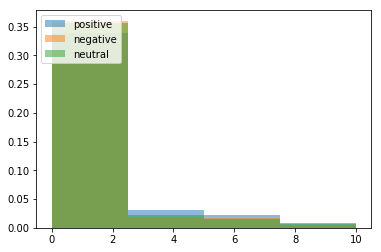

In [49]:
#number of hashtags in a tweet 
bins = np.linspace(0,10,5)
plt.hist(df3[df3['label']=='positive']['hash_count'], bins, alpha =0.5,normed = True, label ='positive')
plt.hist(df3[df3['label']=='negative']['hash_count'], bins, alpha =0.5,normed = True, label ='negative')
plt.hist(df3[df3['label']=='neutral']['hash_count'], bins, alpha =0.5,normed = True, label ='neutral')
plt.legend(loc='upper left')
plt.show()

In [50]:
df3.columns

Index(['user_screen_name', 'user_favorite', 'user_follower', 'retweet',
       'retweet_count', 'retweet_fav_count', 'original_text', 'language',
       'created', 'retweet_created', 'source', 'retweet_source', 'location',
       'retweetID', 'en_ja_word', 'en_ja_goog', 'tweet_link', 'hashtag',
       'hash_count', 'mention', 'mention_count', 'emoji', 'emoji_count',
       'clean_text', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'negative', 'positive', 'r_sentiment',
       'vader_score_word', 'tb_word', 'label', 'punc_count', 'tweet_len',
       'cap_count'],
      dtype='object')

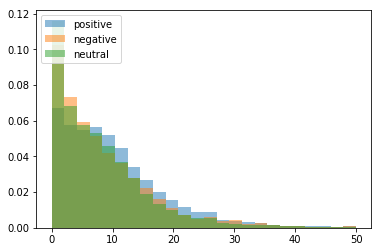

In [51]:
bins = np.linspace(0,50,25)
plt.hist(df3[df3['label']=='positive']['cap_count'], bins, alpha =0.5,normed = True, label ='positive')
plt.hist(df3[df3['label']=='negative']['cap_count'], bins, alpha =0.5,normed = True, label ='negative')
plt.hist(df3[df3['label']=='neutral']['cap_count'], bins, alpha =0.5,normed = True, label ='neutral')
plt.legend(loc='upper left')
plt.show()

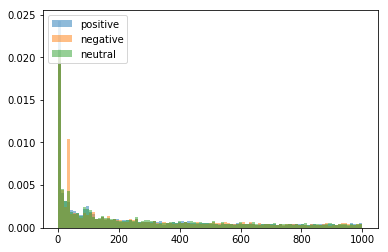

In [52]:
bins = np.linspace(0,1000,100)
plt.hist(df3[df3['label']=='positive']['user_favorite'], bins, alpha =0.5,normed = True, label ='positive')
plt.hist(df3[df3['label']=='negative']['user_favorite'], bins, alpha =0.5,normed = True, label ='negative')
plt.hist(df3[df3['label']=='neutral']['user_favorite'], bins, alpha =0.5,normed = True, label ='neutral')
plt.legend(loc='upper left')
plt.show()

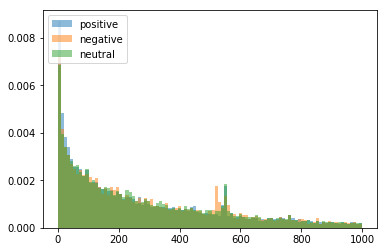

In [53]:
bins = np.linspace(0,1000,100)
plt.hist(df3[df3['label']=='positive']['user_follower'], bins, alpha =0.5,normed = True, label ='positive')
plt.hist(df3[df3['label']=='negative']['user_follower'], bins, alpha =0.5,normed = True, label ='negative')
plt.hist(df3[df3['label']=='neutral']['user_follower'], bins, alpha =0.5,normed = True, label ='neutral')
plt.legend(loc='upper left')
plt.show()


In [58]:
heatmap = df3[['user_favorite', 'user_follower', 'anger', 'hash_count', 'mention_count', 'anticipation', 'disgust', 'fear',
              'joy', 'sadness', 'surprise', 'trust', 'positive', 'negative', 'punc_count', 'tweet_len', 'cap_count']]
corr = heatmap.corr()

In [59]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,user_favorite,user_follower,anger,hash_count,mention_count,anticipation,disgust,fear,joy,sadness,surprise,trust,positive,negative,punc_count,tweet_len,cap_count
user_favorite,1,-0.0032,0.0053,-0.014,0.054,-0.017,0.0076,0.0058,-0.0052,-7.7e-05,-0.0042,-0.0015,-0.0062,-0.00068,0.021,0.0081,0.027
user_follower,-0.0032,1,-0.00015,-0.0072,-0.00083,0.002,0.0048,0.0036,0.0042,0.0059,-0.00021,0.00086,0.0038,0.0044,0.0098,0.0097,0.0059
anger,0.0053,-0.00015,1,-0.027,0.0021,0.14,0.6,0.54,0.13,0.52,0.2,0.16,0.15,0.62,0.016,0.18,0.037
hash_count,-0.014,-0.0072,-0.027,1,-0.038,0.091,-0.037,0.012,0.098,0.0054,0.056,0.041,0.11,0.012,0.6,0.43,0.25
mention_count,0.054,-0.00083,0.0021,-0.038,1,-0.016,0.0038,-0.0016,5.5e-05,-0.0078,-0.005,0.0038,-0.0014,-0.013,0.26,0.21,0.2
anticipation,-0.017,0.002,0.14,0.091,-0.016,1,0.11,0.22,0.66,0.15,0.51,0.49,0.59,0.22,0.18,0.4,0.17
disgust,0.0076,0.0048,0.6,-0.037,0.0038,0.11,1,0.49,0.11,0.5,0.16,0.14,0.11,0.57,0.0024,0.14,0.022
fear,0.0058,0.0036,0.54,0.012,-0.0016,0.22,0.49,1,0.15,0.57,0.23,0.15,0.19,0.65,0.084,0.25,0.11
joy,-0.0052,0.0042,0.13,0.098,5.5e-05,0.66,0.11,0.15,1,0.14,0.55,0.64,0.78,0.14,0.18,0.36,0.14
sadness,-7.7e-05,0.0059,0.52,0.0054,-0.0078,0.15,0.5,0.57,0.14,1,0.16,0.14,0.16,0.66,0.049,0.22,0.066


In [64]:
df3[['user_favorite', 'user_follower', 'anger', 'hash_count', 'mention_count', 'anticipation', 'disgust', 'fear',
              'joy', 'sadness', 'surprise', 'trust', 'positive', 'negative', 'punc_count', 'tweet_len', 'cap_count']].describe()

,user_favorite,user_follower,anger,hash_count,mention_count,anticipation,disgust,fear,joy,sadness,surprise,trust,positive,negative,punc_count,tweet_len,cap_count
count,"87,505.000","87,505.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000","87,510.000"
mean,"21,634.186","9,617.335",0.174,1.055,0.571,0.529,0.137,0.229,0.441,0.203,0.244,0.382,0.789,0.404,6.795,103.565,9.776
std,"46,514.690","367,571.638",0.440,2.410,1.239,0.811,0.389,0.518,0.740,0.472,0.519,0.676,1.055,0.708,5.879,63.420,10.165
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,877.000,95.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,56.000,3.000
50%,"5,775.000",324.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.000,92.000,8.000
75%,"21,280.000",922.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,10.000,130.000,13.000
max,"1,291,782.000","78,807,958.000",5.000,33.000,50.000,8.000,5.000,6.000,10.000,5.000,8.000,7.000,11.000,8.000,122.000,873.000,236.000


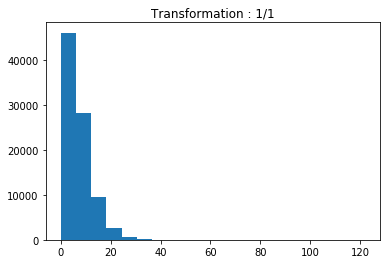

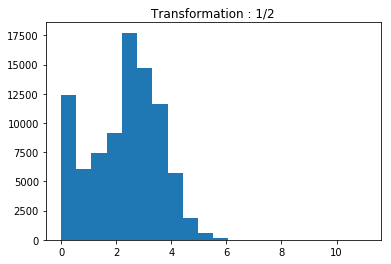

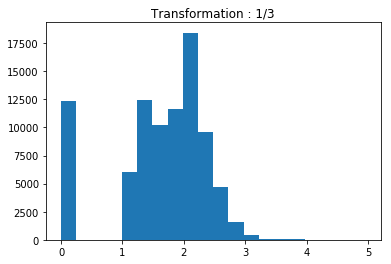

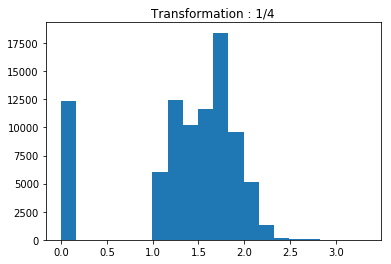

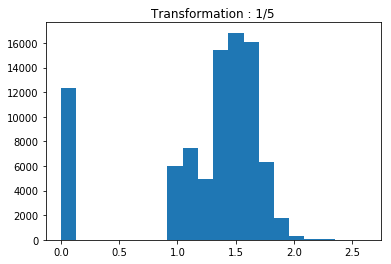

In [67]:
#Box-cox transformation for punct_count
for i in [1,2,3,4,5]:
    plt.hist(df3['punc_count']**(1/i),bins =20)
    plt.title('Transformation : 1/{}'.format(str(i)))
    plt.show()

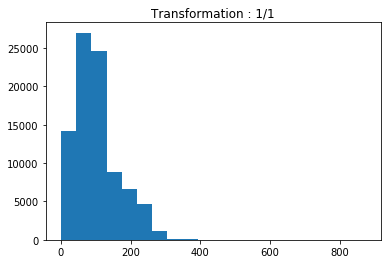

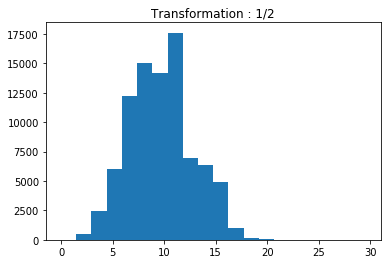

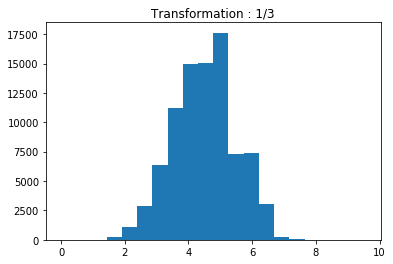

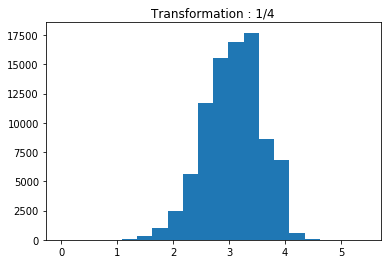

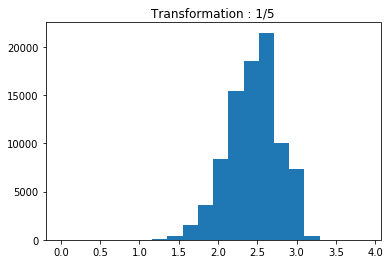

In [67]:
#Box-cox transformation for punct_count
for i in [1,2,3,4,5]:
    plt.hist(df3['tweet_len']**(1/i),bins =20)
    plt.title('Transformation : 1/{}'.format(str(i)))
    plt.show()

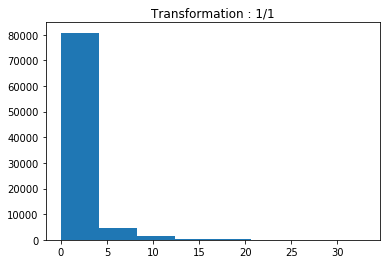

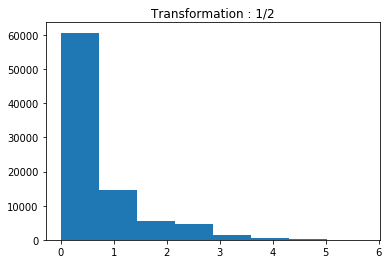

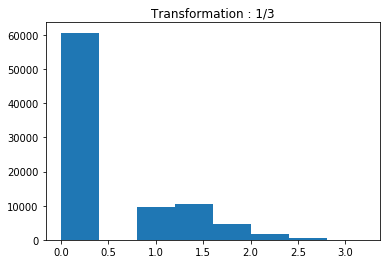

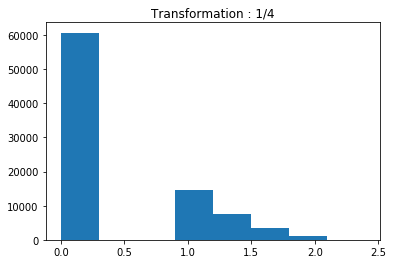

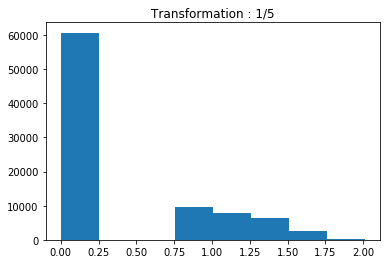

In [69]:
#Box-cox transformation for hashtag count
for i in [1,2,3,4,5]:
    plt.hist(df3['hash_count']**(1/i),bins =8)
    plt.title('Transformation : 1/{}'.format(str(i)))
    plt.show()

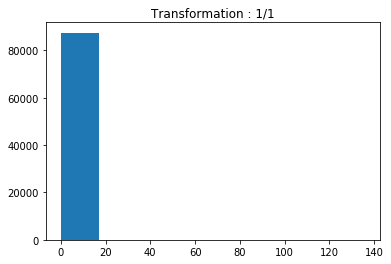

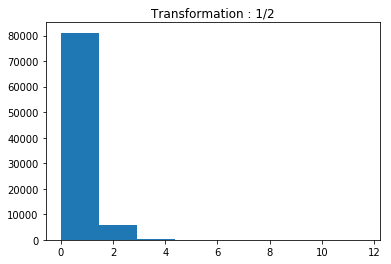

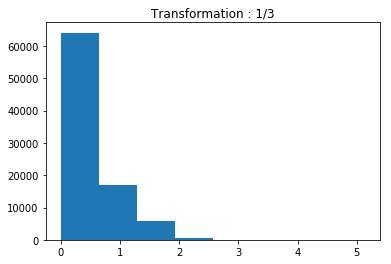

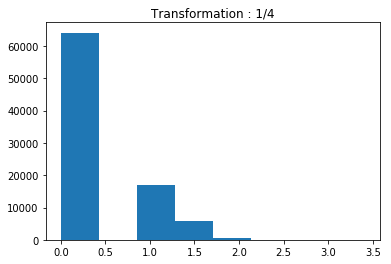

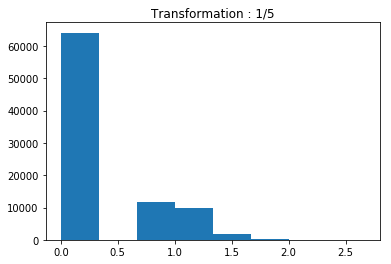

In [63]:
#Box-cox transformation for emoji count
for i in [1,2,3,4,5]:
    plt.hist(df3['emoji_count']**(1/i),bins =8)
    plt.title('Transformation : 1/{}'.format(str(i)))
    plt.show()

/Users/justin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/justin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


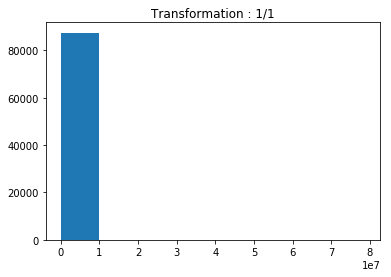

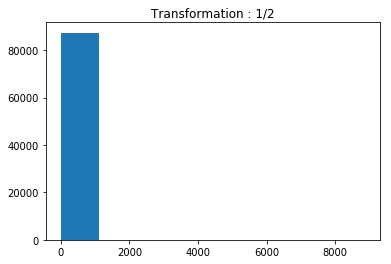

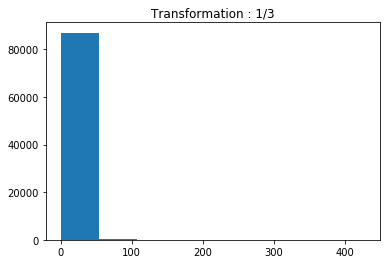

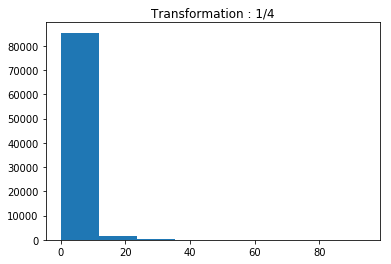

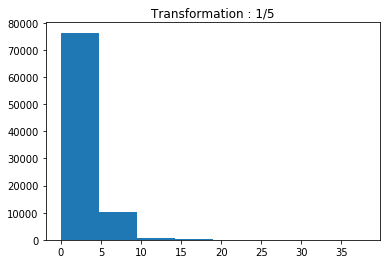

In [65]:
#Box-cox transformation for emoji count
for i in [1,2,3,4,5]:
    plt.hist(df3['user_follower']**(1/i),bins =8)
    plt.title('Transformation : 1/{}'.format(str(i)))
    plt.show()

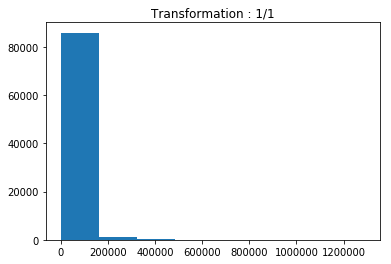

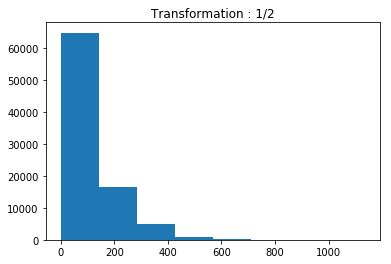

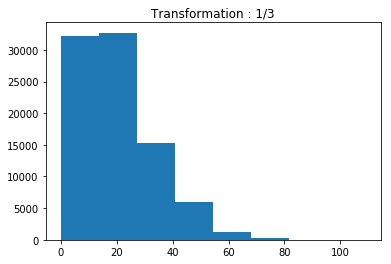

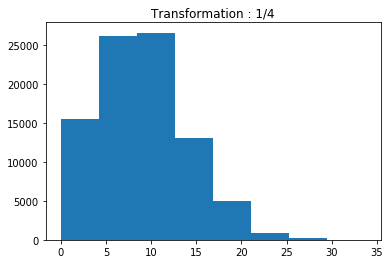

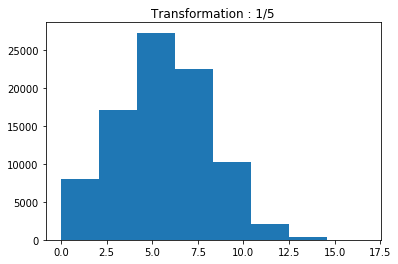

In [66]:
#Box-cox transformation for user_favorite count
for i in [1,2,3,4,5]:
    plt.hist(df3['user_favorite']**(1/i),bins =8)
    plt.title('Transformation : 1/{}'.format(str(i)))
    plt.show()

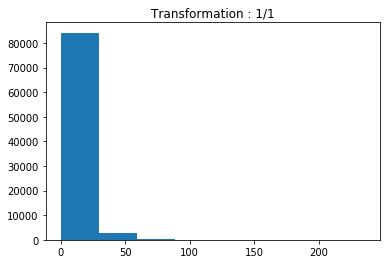

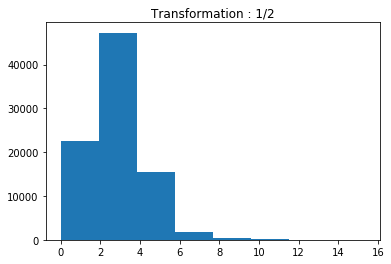

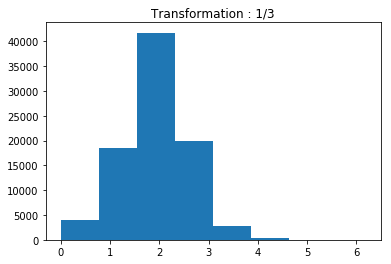

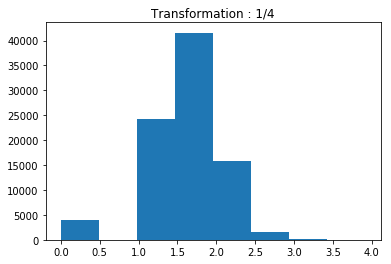

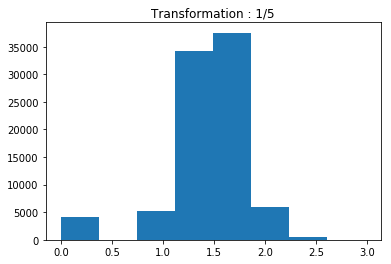

In [68]:
#Box-cox transformation for cap_count count
for i in [1,2,3,4,5]:
    plt.hist(df3['cap_count']**(1/i),bins =8)
    plt.title('Transformation : 1/{}'.format(str(i)))
    plt.show()

In [82]:
#drop columns we won't use for Machine learning and feature engineering
df4 = df3.loc[:,['language', 'hash_count','emoji_count', 'clean_text', 
                 'label', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness',
       'surprise', 'trust', 'punc_count', 'tweet_len',
       'cap_count','user_follower','user_favorite']]

In [83]:
#lets set our categories as categories 
df4['label'] = df4['label'].astype('category')
df4['language'] = df4['language'].astype('category')


In [84]:
#2 is positive, 1 is neutral, 0 is negative
df4['label'] = df4['label'].cat.codes


In [85]:
df_ja = df4[df4['language'] == 'ja']
df_en = df4[df4['language'] == 'en']

In [86]:
df_en['label'] = df_en['label'].replace(0,3)
df_en['label'] = df_en['label'].replace(1,4)
df_en['label'] = df_en['label'].replace(2,5)

/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [87]:
df = pd.concat([df_ja,df_en])

In [88]:
df = df.drop(columns = 'language')

In [89]:
df.to_json('DiSmldata.json')

In [12]:
# Lets's look at our 3 grams 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'],test_size =0.20, random_state = 77)

In [14]:
ngram_vect = CountVectorizer(ngram_range=(3,3), max_features = 10000, stop_words = my_stop_words)
ngram_train = ngram_vect.fit_transform(X_train)
ngram_test = ngram_vect.transform(X_test)

In [18]:
X_ngram_df = pd.DataFrame(ngram_train.A, columns = ngram_vect.get_feature_names())
X_ngram_df = X_ngram_df.transpose()

In [19]:
#top 20 words for each retweet 
top_dict = {}
for c in X_ngram_df.columns:
    top = X_ngram_df[c].sort_values(ascending=False).head(20)
    top_dict[c]= list(zip(top.index, top.values))
#word count
n_words = []
for tweet in X_ngram_df.columns:
    top = [word for (word, count) in top_dict[tweet] if count != 0]
    for t in top:
        n_words.append(t)

In [20]:
pd.DataFrame(Counter(n_words).most_common())[0:20]

,0,1
0,happiest place earth,344
1,lowest waiting time,243
2,star wars galaxys,233
3,wars galaxys edge,230
4,highest waiting time,216
5,oogie boogie bash,170
6,spooky boo parade,121
7,min toy story,121
8,radiator springs racers,119
9,indiana jones adventure,108
